In [1]:
library(stringi)
library(EnhancedVolcano)

Warning message:
“package ‘EnhancedVolcano’ was built under R version 4.3.2”
Loading required package: ggplot2

Loading required package: ggrepel



In [2]:
annotation <- read.table("dea/annotation.bed", header=FALSE, sep="\t", col.names = c("chr", "start", "end", "name", "score", "strand", "type", "gene.id", "gene", "transcripts", "databases"))
# Remove chr, start, end, score, strand, gene.id, transcripts
annotation$chr <- NULL
annotation$start <- NULL
annotation$end <- NULL
annotation$score <- NULL
annotation$strand <- NULL
annotation$gene.id <- NULL
annotation$transcripts <- NULL
annotation$has_db <- annotation$databases != "."

rownames(annotation) <- annotation$name
annotation$name <- NULL

In [3]:
work_dir <- "ciriquant/work"
circ_dir <- "ciriquant/circs"
stringtie_dir <- "ciriquant/transcripts"
outdir = "../chapters/4_results_and_discussion/figures/dea/ciriquant/"

In [4]:
create_df <- function(samples, condition) {
  ciri_files <- file.path(circ_dir, paste0(samples, ".gtf"))
  stringtie_files <- file.path(stringtie_dir, paste0(samples, "_out.gtf"))
  conditions <- rep(condition, length(samples))
  return(data.frame("ciri" = ciri_files, "condition" = conditions, "stringtie" = stringtie_files, row.names = samples))
}

ciri_prepde <- function(df, wd) {
  samplesheet <- file.path(wd, "samplesheet_ciri.tsv")
  write.table(df, samplesheet, sep = "\t", quote = FALSE, row.names = TRUE, col.names = FALSE)

  lib_file <- file.path(wd, "lib_ciri.csv")
  circ_file <- file.path(wd, "circ_ciri.csv")
  bsj_file <- file.path(wd, "bsj_ciri.csv")
  ratio_file <- file.path(wd, "ratio_ciri.csv")

  command <- paste("prep_CIRIquant -i", samplesheet, "--lib", lib_file, "--circ", circ_file, "--bsj", bsj_file, "--ratio", ratio_file)
  print(command)
  system(command)

  return(list(lib_file, circ_file, bsj_file, ratio_file))
}

stringtie_prepde <- function(df, wd) {
  samplesheet <- file.path(wd, "samplesheet_stringtie.tsv")
  write.table(df, samplesheet, sep = "\t", quote = FALSE, row.names = TRUE, col.names = FALSE)

  gene_file <- file.path(wd, "gene.csv")
  transcript_file <- file.path(wd, "transcript.csv")

  command <- paste("prepDE.py -i", samplesheet, "-g", gene_file, "-t", transcript_file)
  print(command)
  system(command)

  return(list(gene_file, transcript_file))
}

ciriquant_de <- function(lib_file, bsj_file, gene_file, wd) {
  gene_results <- file.path(wd, "gene_results.csv")
  circ_results <- file.path(wd, "circ_results.csv")

  command <- paste("CIRI_DE_replicate --lib", lib_file, "--bsj", bsj_file, "--gene", gene_file, "--out", circ_results, "--out2", gene_results)
  print(command)
  system(command)

  return(list(gene_results, circ_results))
}

In [5]:
run <- function(control, treatment) {
  control_df <- create_df(control, "C")
  treatment_df <- create_df(treatment, "T")
  df <- rbind(control_df, treatment_df)

  tryCatch({
    temp_dir <- file.path(work_dir, stri_rand_strings(1, 10))
    dir.create(temp_dir, recursive = TRUE,showWarnings = FALSE)

    p_ciri <- ciri_prepde(df[c("ciri", "condition")], temp_dir)
    p_stringtie <- stringtie_prepde(df[c("stringtie")], temp_dir)

    p_ciri_de <- ciriquant_de(p_ciri[[1]], p_ciri[[3]], p_stringtie[[1]], temp_dir)

    df_gene <- read.csv(p_ciri_de[[1]], row.names = 1)
    df_circ <- read.csv(p_ciri_de[[2]], row.names = 1)

    df_circ <- cbind(df_circ, annotation[rownames(df_circ),])

    return(df_circ)
  },
  finally = {
    unlink(temp_dir, recursive = TRUE)
  })
}

In [6]:
phenotype <- read.csv("dea/phenotype.csv", header=TRUE, row.names = 1)
phenotype$transgene <- as.factor(phenotype$transgene)
phenotype$drug <- as.factor(phenotype$drug)
head(phenotype)

,condition,age,transgene,induction,drug,replicate
,<chr>,<int>,<fct>,<int>,<fct>,<int>
aging_12m_ESR1_no_1,12_ESR1_0_no,12,ESR1,0,no,1
aging_12m_ESR1_no_2,12_ESR1_0_no,12,ESR1,0,no,2
aging_12m_ESR1_no_3,12_ESR1_0_no,12,ESR1,0,no,3
aging_12m_ESR1_1w_1,12_ESR1_1_no,12,ESR1,1,no,1
aging_12m_ESR1_1w_2,12_ESR1_1_no,12,ESR1,1,no,2
aging_12m_ESR1_1w_3,12_ESR1_1_no,12,ESR1,1,no,3


# Tamoxifen

In [7]:
df_control <- phenotype[phenotype$drug == "no",]
df_treatment <- phenotype[phenotype$drug == "tamoxifen",]

res_tamoxifen <- run(rownames(df_control), rownames(df_treatment))

[1] "prep_CIRIquant -i ciriquant/work/FA2FB7EsnV/samplesheet_ciri.tsv --lib ciriquant/work/FA2FB7EsnV/lib_ciri.csv --circ ciriquant/work/FA2FB7EsnV/circ_ciri.csv --bsj ciriquant/work/FA2FB7EsnV/bsj_ciri.csv --ratio ciriquant/work/FA2FB7EsnV/ratio_ciri.csv"
[1] "prepDE.py -i ciriquant/work/FA2FB7EsnV/samplesheet_stringtie.tsv -g ciriquant/work/FA2FB7EsnV/gene.csv -t ciriquant/work/FA2FB7EsnV/transcript.csv"
[1] "CIRI_DE_replicate --lib ciriquant/work/FA2FB7EsnV/lib_ciri.csv --bsj ciriquant/work/FA2FB7EsnV/bsj_ciri.csv --gene ciriquant/work/FA2FB7EsnV/gene.csv --out ciriquant/work/FA2FB7EsnV/circ_results.csv --out2 ciriquant/work/FA2FB7EsnV/gene_results.csv"


Saving 6.67 x 6.67 in image


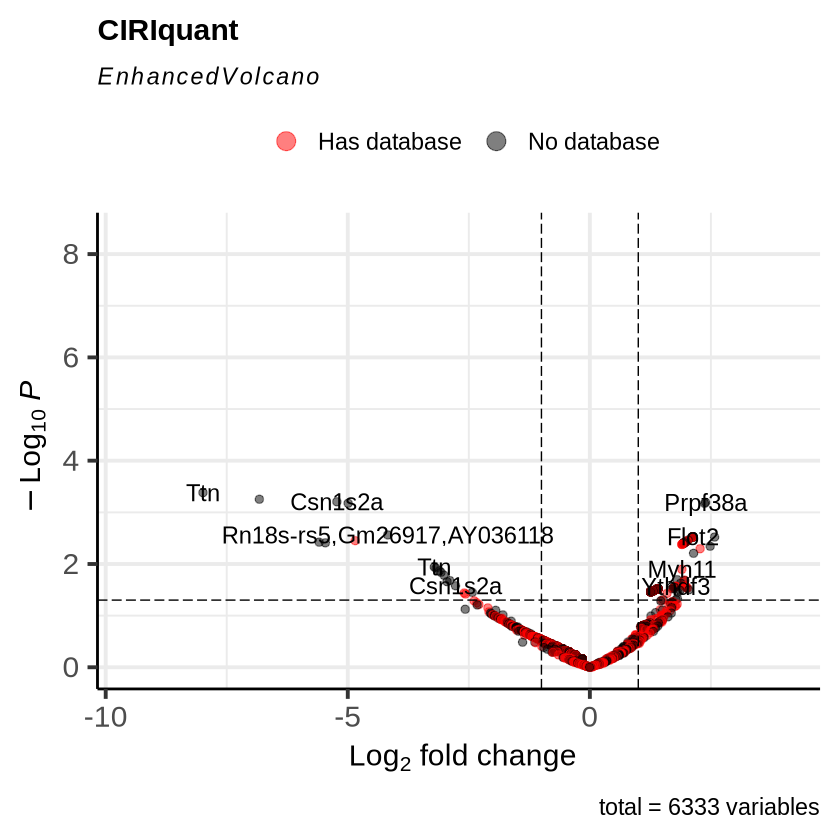

In [8]:
directory <- file.path(outdir, "tamoxifen")
dir.create(directory, recursive = TRUE, showWarnings = FALSE)
colors <- ifelse(res_tamoxifen$has_db, "red", "black")
names(colors) <- ifelse(res_tamoxifen$has_db, "Has database", "No database")

EnhancedVolcano(res_tamoxifen,
    x='logFC',
    y='PValue',
    title="CIRIquant",
    colCustom=colors,
    lab=res_tamoxifen$gene,
    pCutoff = 0.05)

ggsave(file.path(directory, "volcano.png"))
write.table(res_tamoxifen, file.path(directory, "results.tsv"), sep = "\t", quote = FALSE, row.names = TRUE, col.names = NA)

# Letrozole

In [9]:
df_control <- phenotype[phenotype$drug == "no",]
df_treatment <- phenotype[phenotype$drug == "letrozole",]

res_letrozole <- run(rownames(df_control), rownames(df_treatment))

[1] "prep_CIRIquant -i ciriquant/work/OUz3bRKW0o/samplesheet_ciri.tsv --lib ciriquant/work/OUz3bRKW0o/lib_ciri.csv --circ ciriquant/work/OUz3bRKW0o/circ_ciri.csv --bsj ciriquant/work/OUz3bRKW0o/bsj_ciri.csv --ratio ciriquant/work/OUz3bRKW0o/ratio_ciri.csv"
[1] "prepDE.py -i ciriquant/work/OUz3bRKW0o/samplesheet_stringtie.tsv -g ciriquant/work/OUz3bRKW0o/gene.csv -t ciriquant/work/OUz3bRKW0o/transcript.csv"
[1] "CIRI_DE_replicate --lib ciriquant/work/OUz3bRKW0o/lib_ciri.csv --bsj ciriquant/work/OUz3bRKW0o/bsj_ciri.csv --gene ciriquant/work/OUz3bRKW0o/gene.csv --out ciriquant/work/OUz3bRKW0o/circ_results.csv --out2 ciriquant/work/OUz3bRKW0o/gene_results.csv"


Saving 6.67 x 6.67 in image


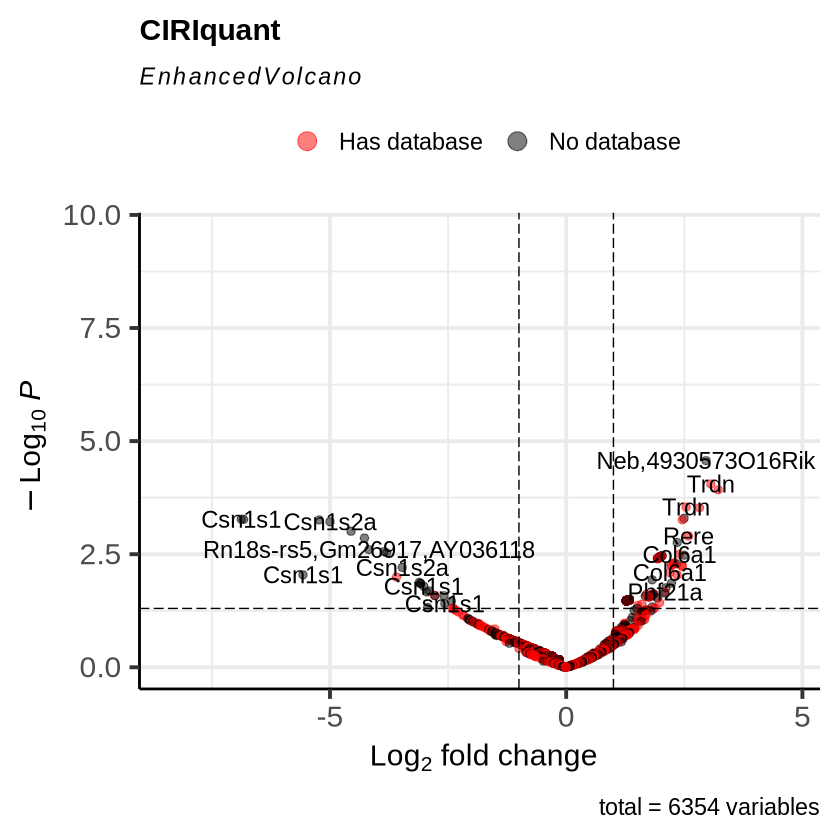

In [10]:
directory <- file.path(outdir, "letrozole")
dir.create(directory, recursive = TRUE, showWarnings = FALSE)

colors <- ifelse(res_letrozole$has_db, "red", "black")
names(colors) <- ifelse(res_letrozole$has_db, "Has database", "No database")

EnhancedVolcano(res_letrozole,
    x='logFC',
    y='PValue',
    title="CIRIquant",
    colCustom=colors,
    lab=res_letrozole$gene,
    pCutoff = 0.05)

ggsave(file.path(directory, "volcano.png"))
write.table(res_letrozole, file.path(directory, "results.tsv"), sep = "\t", quote = FALSE, row.names = TRUE, col.names = NA)